In [4]:
import kagglehub
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [5]:
# Download latest version
path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")
print("Path to dataset files:", path)
path = path + "/kagglecatsanddogs_3367a/PetImages"



Path to dataset files: /Users/aman/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1


In [6]:
files = os.listdir(path)

animal = []

for file in files:
    
    if file != ".DS_Store":
        animal.append(os.path.join(path, file))

print(animal)



['/Users/aman/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat', '/Users/aman/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog']


In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

my_data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}





In [8]:
data_dir = 'hymenoptera_data'

# dog_dir = animal[1]

data_check = "/Users/aman/Stuff/Programming/CatVsDog/Cat_Dog"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}  

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}



my_image_datasets = {x: datasets.ImageFolder(os.path.join(data_check, x), my_data_transforms[x]) for x in ['Train', 'Validation']}

my_dataloaders = {x: torch.utils.data.DataLoader(my_image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['Train', 'Validation']}

my_dataset_sizes = {x: len(my_image_datasets[x]) for x in ["Train", "Validation"]}




print(my_image_datasets)
print("--------------------------------------")
print(my_dataloaders)

{'Train': Dataset ImageFolder
    Number of datapoints: 9940
    Root location: /Users/aman/Stuff/Programming/CatVsDog/Cat_Dog/Train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'Validation': Dataset ImageFolder
    Number of datapoints: 2486
    Root location: /Users/aman/Stuff/Programming/CatVsDog/Cat_Dog/Validation
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}
--------------------------------------
{'Train': <torch.utils.data.dataloader.DataLoader object a

In [9]:
class_names = image_datasets['train'].classes
my_class_names = my_image_datasets['Train'].classes # Gives a list of the different type of images

print(my_class_names)

['Cats', 'Dogs']


In [10]:
if torch.accelerator.is_available():
    current_device = torch.accelerator.current_accelerator()
else:
    current_device = torch.device("cpu")
if current_device.type == 'cuda':
    is_half_supported = torch.cuda.has_half
elif current_device.type == 'xpu':
    is_half_supported = torch.xpu.get_device_properties().has_fp16
elif current_device.type == 'cpu':
    is_half_supported = True

In [11]:
print(torch.__version__)
print()

2.6.0



In [12]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(device)

mps


In [13]:
inputs, classes = next(iter(dataloaders['train']))
my_inputs, my_classes = next(iter(my_dataloaders["Train"]))



In [14]:
my_out = torchvision.utils.make_grid(my_inputs, padding = 10)
out = torchvision.utils.make_grid(my_inputs, padding = 10)
print(type(my_out))

print(type(my_class_names))


<class 'torch.Tensor'>
<class 'list'>


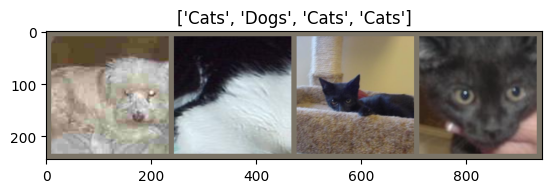

2


In [15]:
def imshow(inp, title = None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

imshow(my_out, title = [my_class_names[x] for x in classes]) # out is a tensor and my_class_names is a list

print(len(my_class_names))

In [16]:
def train_model(model, criterion, optimizer, schedular, num_epochs = 25):
    since = time.time()
    withupdate = 0
    
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt') #This creates a new model 
        print(f"Updated with: {withupdate}")
        withupdate += 1

        torch.save(model.state_dict(), best_model_params_path)#Saves the model
        best_acc = 0.0 #accuracy of the model

        for epoche in range(num_epochs):
            print(f"Epoche: {epoche}/{num_epochs - 1}")
            print("-" * 10)
            
            
            for phase in ["Train", "Validation"]:
                if phase == "Train":
                    model.train()
                else:
                    model.eval()

                print(f"Current phase:{phase}")

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in my_dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == "Train"): #sets gradient calculations on or off
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == "Train":
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == "Train":
                    schedular.step()
                    print(f"Schedular.step")

                epoche_loss = running_loss / my_image_datasets[phase]   
                epoche_acc = running_corrects.double() / my_dataset_sizes[phase]

                print(f"{phase} Loss: {epoche_loss:.4f} Acc: {epoche_acc:.4f}")

                if phase == 'Validation' and epoche_acc > best_acc:
                    best_acc = epoche_acc
                    torch.save(model.state_dict(), best_model_params_path)
            print()
            
        time_elapsed = time.time() - since

        print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
        print(f"Best val acc: {best_acc:4f}")

        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    return model





# train_model(0,0,0,0,0)

In [17]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Updated with: 0
Epoche: 0/24
----------
Current phase:Train
